## FUNZIONI

In [ ]:
# libreria pyvis per visualizzare il grafo
!pip install -q pyvis #-q flag non visualizza l'output durante l'installazione

# libreria pywaffle per visualizzare pictorial fraction charts
!pip install -q pywaffle

     |████████████████████████████████| 1.6 MB 9.1 MB/s 
     |████████████████████████████████| 25.1 MB 11.0 MB/s 


In [ ]:
# per manipolazione dataset
import pandas as pd
import numpy as np
import re
import seaborn as sns

# per lavorare col grafo
import networkx as nx
import matplotlib.pyplot as plt
import cv2 as cv
from pyvis.network import Network # visualizzazione con pyvis

# algoritmo di modularity maximization per community detection
from networkx.algorithms.community import greedy_modularity_communities
# per score modularity
import networkx.algorithms.community as nx_comm
# centrality measures
from networkx.algorithms.centrality import (closeness_centrality, betweenness_centrality,
                                            harmonic_centrality)

# wordcloud
from wordcloud import WordCloud
# per eliminare stopwords dalla wordcloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import math

# per visualizzazione sentiment
from pywaffle import Waffle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("###", sep = ",")

In [ ]:
df.head()

,date,id,text,n_rt,n_like,author_name,author_id,location,rt_authors,author_follower,author_friends
0,2022-09-01 10:51:41+00:00,1565291297640009728,"Ehi, sarà mica il #Giornodellamarmotta ?\n\nFe...",1,0,whilecromar,347209343,Milano - Cremona - Parma,"[{'screen_name': 'terzopolomeme', 'name': 'Ter...",707,1323
1,2022-09-01 10:51:38+00:00,1565291282053881857,#Elezioni2022 #ElezioniPolitiche\n\nElenco dei...,1,0,GiuliaTulla,113398061,NaN,"[{'screen_name': 'OrioliAlberto', 'name': 'Alb...",1935,1766
2,2022-09-01 10:51:36+00:00,1565291275208822784,"Eh sì, stamattina ho avuto un brutto risveglio...",0,0,CapoOrsoInPiedi,1024757342066421761,NaN,[],417,899
3,2022-09-01 10:51:27+00:00,1565291238424805379,Scusate la classe.....😜😂😂😂\n#ElezioniPolitiche...,7,0,AndreaCalussi,1295089147456172032,NaN,"[{'screen_name': 'AlessandraOdri', 'name': 'Al...",39,90
4,2022-09-01 10:51:07+00:00,1565291155377602562,#Elezioni2022 \nEuropa Verde ha pubblicato una...,35,0,sergiopbaviera,34617925,"Palermo, Italy","[{'screen_name': 'ultimora_pol', 'name': 'Ulti...",922,2631


In [ ]:
# estraggo i nomi degli utenti retweettati dalla stringa 
def extract_name_from_retweed_authors(str_mention): 
  lst_names = [] 
 
  # cerco la parola screen_name nella stringa e mi posiziono alla fine di essa 
  start_idx = str_mention.find('screen_name') 
 
  while start_idx != -1: 
    # mi porto all'inizio dello screen_name, l'indice infatti è all'inizio della parola screen_name 
    start_idx += 15 
    # cerco dove finisce l'apostrofo -> i.e. fine del nome utente 
    end_idx = start_idx + str_mention[start_idx:].find("'") 
    # salvo il nome utente trovato 
    aut_name = str_mention[start_idx:end_idx] 
    # cancello la porzione di stringa già analizzata 
    str_mention = str_mention[end_idx:] 
    # cerco se c'è un secondo nome nella lista di retweettati 
    start_idx = str_mention.find('screen_name') 
 
    lst_names.extend([aut_name]) 
 
  return lst_names

In [ ]:
df['rt_names'] = df['rt_authors'].apply(extract_name_from_retweed_authors) 

## COSTRUZIONE GRAFO

In [ ]:
df.head()

,date,id,text,n_rt,n_like,author_name,author_id,location,rt_authors,author_follower,author_friends,rt_names
0,2022-09-01 10:51:41+00:00,1565291297640009728,"Ehi, sarà mica il #Giornodellamarmotta ?\n\nFe...",1,0,whilecromar,347209343,Milano - Cremona - Parma,"[{'screen_name': 'terzopolomeme', 'name': 'Ter...",707,1323,"[terzopolomeme, gar_fal, CarloCalenda]"
1,2022-09-01 10:51:38+00:00,1565291282053881857,#Elezioni2022 #ElezioniPolitiche\n\nElenco dei...,1,0,GiuliaTulla,113398061,NaN,"[{'screen_name': 'OrioliAlberto', 'name': 'Alb...",1935,1766,[OrioliAlberto]
2,2022-09-01 10:51:36+00:00,1565291275208822784,"Eh sì, stamattina ho avuto un brutto risveglio...",0,0,CapoOrsoInPiedi,1024757342066421761,NaN,[],417,899,[]
3,2022-09-01 10:51:27+00:00,1565291238424805379,Scusate la classe.....😜😂😂😂\n#ElezioniPolitiche...,7,0,AndreaCalussi,1295089147456172032,NaN,"[{'screen_name': 'AlessandraOdri', 'name': 'Al...",39,90,[AlessandraOdri]
4,2022-09-01 10:51:07+00:00,1565291155377602562,#Elezioni2022 \nEuropa Verde ha pubblicato una...,35,0,sergiopbaviera,34617925,"Palermo, Italy","[{'screen_name': 'ultimora_pol', 'name': 'Ulti...",922,2631,[ultimora_pol]


In [ ]:
# Construzione del grafo orientato e pesato
weight_graph = nx.DiGraph()

# creo il grafo collegando l'utente agli altri utenti con cui ha avuto interazioni (retweet)
for _, row in df.iterrows():
  # per ogni utente scorro la lista degli utenti menzionati, possono essere anche
  # più di uno (retweet + menzione nel post)
  for element in row['rt_names']:
    # se esiste già l'arco ne aggiorno solo il peso
    if weight_graph.has_edge(row['author_name'], element):
      weight_graph[row['author_name']][element]['weight'] += 1
    # se l'arco non esiste lo creo con peso = 1.
    # In automatico crea anche i nodi se necessario
    else:
      weight_graph.add_edge(row['author_name'], element, weight = 1)

In [ ]:
print('Nodi:', weight_graph.number_of_nodes())
print('Archi:', weight_graph.number_of_edges())

Nodi: 12947
Archi: 27096


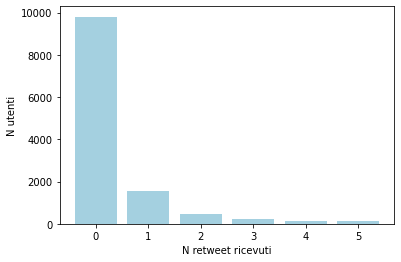

In [ ]:
#produciamo un barchart per valutare quanti utenti hanno ricevuto pochi retweets, pari ad un numero minore di 5
objects = ('0','1','2','3','4','5')
degrees = sorted([weight_graph.in_degree(n) for n in weight_graph.nodes()])

uno=0
due=0
tre=0
qua=0
cin=0
zer=0
for el in degrees:
    if el == 0:
        zer+=1
    if el == 1:
        uno+=1
    if el == 2:
        due+=1
    if el == 3:
        tre+=1
    if el == 4:
        qua+=1
    if el == 5:
        cin+=1
        
performance=[]
performance.append(zer)
performance.append(uno)
performance.append(due)
performance.append(tre)
performance.append(qua)
performance.append(cin)

# per settare i ticks dell'asse x
y_pos = np.arange(len(objects))
 
# visualizzo il grafo
plt.bar(y_pos, performance, align='center', alpha=0.5, color='#4ba3c3')
plt.xticks(y_pos, objects)
plt.ylabel('N utenti')
plt.xlabel('N retweet ricevuti')
#plt.title('0-5 retweet ricevuti')
plt.show()

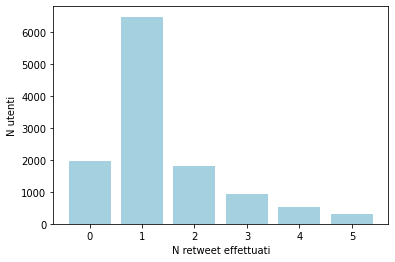

In [ ]:
#produciamo un barchart per valutare quanti utenti hanno ricevuto pochi retweets, pari ad un numero minore di 5
objects = ('0','1','2','3','4','5')
degrees = sorted([weight_graph.out_degree(n) for n in weight_graph.nodes()])

uno=0
due=0
tre=0
qua=0
cin=0
zer=0
for el in degrees:
    if el == 0:
        zer+=1
    if el == 1:
        uno+=1
    if el == 2:
        due+=1
    if el == 3:
        tre+=1
    if el == 4:
        qua+=1
    if el == 5:
        cin+=1
        
performance=[]
performance.append(zer)
performance.append(uno)
performance.append(due)
performance.append(tre)
performance.append(qua)
performance.append(cin)

# per settare i ticks dell'asse x
y_pos = np.arange(len(objects))
 
# visualizzo il grafo
plt.bar(y_pos, performance, align='center', alpha=0.5, color='#4ba3c3')
plt.xticks(y_pos, objects)
plt.ylabel('N utenti')
plt.xlabel('N retweet effettuati')
#plt.title('0-5 retweet effettuati')
plt.show()

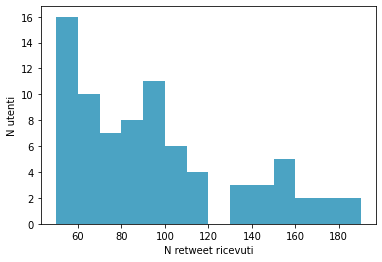

In [ ]:
def plot_degree_dist(G):
    bins=np.arange(50, 200, 10)  
    degrees = sorted([G.in_degree(n) for n in G.nodes()])
    plt.hist(degrees, bins, color='#4ba3c3')
    plt.ylabel('N utenti')
    plt.xlabel('N retweet ricevuti')
    #plt.title('10-70 retweet ricevuti')
    plt.show()

plot_degree_dist(weight_graph)

In [ ]:
#lista per la dimensione dei nodi
lst_node_size = []
# dizionario per il nome dei nodi
dict_node_labels = {}
# lista per i colori dei nodi (default = blu, solo retweet = verde)
lst_node_color = []

for node in weight_graph:
  # verifico se il nodo ha più di 50 archi entranti
  if weight_graph.in_degree(node, weight = 'weight') >= 150:
    # aumento la dimensione
    lst_node_size.append(9000)
    # salvo la label del nodo per visualizzarla
    dict_node_labels[node] = str(node)
  # se ha meno di 50 archi entranti ne diminuisco la dimensione e rimuovo la label
  else:
    # riduto a 100 la dimensione del nodo (dim_predefinita = 300)
    lst_node_size.append(100) 
    # rimuovo la label dalla visualizzazione
    dict_node_labels[node] = ' '

  # Se il nodo non ha archi uscenti lo coloro di verde -> nodo che ha solo menzioni
  if weight_graph.out_degree(node) == 0:
    lst_node_color.append('#8ee3a7')
  # altrimenti lascio il colore di default: il blu
  else:
    lst_node_color.append('#70b1d4')

## GRAFO

In [ ]:
# Aumento la dimensione del grafo
plt.figure(figsize =(30,30), dpi=100)

# calcolo la posizione dei nodi nel grafo
pos = nx.spring_layout(weight_graph, weight='weight')

# visualizzo il grafo appena costruito
nx.draw_networkx(weight_graph, edge_color='#dee2e6', node_size = lst_node_size,
                 labels=dict_node_labels, with_labels = True, font_size=18,
                 node_color = lst_node_color, pos = pos)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Definisco gli attributi richiesti da pyvis per visualizzare opportunamente
# le label dei nodi e le rispettive grandezze
for node in weight_graph:
  # verifico se il nodo ha una in_degree pesata maggiore a 150
  if weight_graph.in_degree(node, weight = 'weight') >= 150:
    weight_graph.nodes[node]['label'] = str(node) # ne visualizzo il nome
    weight_graph.nodes[node]['size'] = 100 # ingrandisco il nodo
    # definisco la forma (cosi la label è visualizzata all'interno del nodo e non sotto)
    weight_graph.nodes[node]['shape'] = 'circle' 
  else:
    # tolgo la label dai nodi con in_degree < 150
    weight_graph.nodes[node]['label'] = ' ' 

  weight_graph.nodes[node]['title'] = str(node)

In [ ]:
net = Network(height = '1024px', width = "100%", directed=True) # notebook = True -> non va su colab
# setto alcune opzioni extra per  migliorare la visualizzazione
net.set_options("""
var options = {
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": {
      "type": "continuous",
      "forceDirection": "none",
      "roundness": 0.65
    }
  },
  "physics": {
    "forceAtlas2Based": {
      "springLength": 100
    },
    "minVelocity": 0.55,
    "solver": "forceAtlas2Based"
  },
  "interaction": {
    "navigationButtons": true
  }
}
""")

# populates the nodes and edges data structures
net.from_nx(weight_graph)
net.write_html('grafo_base.html') # esporto la pagina html

In [ ]:
# top 15 account con più follower

df_sorted = df.sort_values(by = ['author_follower'], ascending=False)
df_sorted = df_sorted.drop_duplicates(subset = ['author_name'])

df_sorted[['author_name', 'author_follower']].head(15)

,author_name,author_follower
32445,SkyTG24,3618733
35516,TwitterGov,2371841
34761,fattoquotidiano,2179846
33124,sole24ore,1741955
2266,marcotravaglio,1652190
8295,MediasetTgcom24,1407494
30101,TgLa7,770899
26582,EnricoLetta,716015
28858,ilpost,713621
1248,meb,654120


In [ ]:
# top 15 account con più follower tra nodi etichettati

df_sorted = df_sorted[df_sorted['author_name'].isin(dict_node_labels.values())]

df_sorted[['author_name', 'author_follower']].head(15)

,author_name,author_follower
26582,EnricoLetta,716015
1248,meb,654120
28753,pdnetwork,400377
24633,CarloCalenda,396478
28635,DSantanche,191621
33153,FratellidItalia,182051
28838,gparagone,172004
33144,Cartabellotta,76223
18065,PossibileIt,58214
31395,fdragoni,54974


In [ ]:
# metriche
assortativity = nx.degree_assortativity_coefficient(weight_graph, weight='weight')
node_conn = nx.node_connectivity(weight_graph)
edge_conn = nx.edge_connectivity(weight_graph)
density = nx.density(weight_graph)
overall_reciprocity = nx.overall_reciprocity(weight_graph)
scc = nx.number_strongly_connected_components(weight_graph)
nnodes = weight_graph.number_of_nodes()
deg = sum(d for n, d in weight_graph.degree(weight='weight')) / (2*float(nnodes))

print('Average degree:', deg)
print('Graph density:', round(density,6))
print('Node connectivity:', node_conn)
print('Edge connectivity:', edge_conn)
print('Assortativity:', round(assortativity,4))
print('Overall_reciprocity:', round(overall_reciprocity,5))
print('Number of strongly connected component:', scc)

Average degree: 2.8090677376998534
Graph density: 0.000162
Node connectivity: 0
Edge connectivity: 0
Assortativity: -0.0616
Overall_reciprocity: 0.01705
Number of strongly connected component: 12678


In [ ]:
# closeness centrality
cc_dict = dict(closeness_centrality(weight_graph))
ordered_cc = dict(sorted(cc_dict.items(), key=lambda item: item[1], reverse = True))

i = 0
for key, value in ordered_cc.items():
  print(key + ': ' + str(value))
  i = i + 1
  if i == 10:
    break

ultimora_pol: 0.12764827203933332
GiorgiaMeloni: 0.08385780141836764
pdnetwork: 0.07474060831358177
peppeprovenzano: 0.06002704548119922
EnricoLetta: 0.05869262042111099
FratellidItalia: 0.057574080311071404
ilgiornale: 0.051163355625758654
FrancescoLollo1: 0.05114010900682359
direpuntoit: 0.050499546649097796
robertomenia: 0.049581964347840735


In [ ]:
#betweenness centrality
bcGC_dict = dict(betweenness_centrality(weight_graph, weight='weight'))
ordered_bcGC = dict(sorted(bcGC_dict.items(), key=lambda item: item[1], reverse = True))

i = 0
for key, value in ordered_bcGC.items():
  print(key + ': ' + str(value))
  i = i + 1
  if i == 10:
    break

ambrosimirko44: 0.003166566481797411
Yoda15271485: 0.001761261437830426
Rapace781: 0.0016948693912287552
Finiguerra: 0.0015943479301999113
romano_tano: 0.001568531002025047
BuselliGiulia: 0.0015410112109576234
UPtrieste: 0.0015226751645405908
demagistris: 0.0011902842702816443
Marzo531: 0.0011038410811064255
radionowher: 0.0010956959351882606


## COMMUNITY DETECTION

In [ ]:
# estraggo le community utilizzando l'algoritmo di modularity maximization
comm = list(greedy_modularity_communities(weight_graph, weight='weight'))

# visualizzo alcune informazioni di base
print('Numero community:', len(comm))
print('Modularity:', nx_comm.modularity(weight_graph, comm, weight='weight'))

Numero community: 351
Modularity: 0.7123478127472167


In [ ]:
# creo una nuova colonna nel dataframe per rappresentare il cluster
df['cluster'] = -1

c_index = -1
# itero su ogni community trovata
for c in comm:
  c_index = c_index + 1
  # per ogni autore (nodo del grafo) presente nella community salvo il corrispettivo numero di cluster
  for name in list(c):
    df.loc[df['author_name'] == name, 'cluster'] = c_index

# elimino le righe con cluster = -1
df = df[df.cluster != -1]

In [ ]:
# estraggo i cluster che contengono degli hub in base all'autore del post
lst_cluster_hub = df[df['author_name'].isin(dict_node_labels.values())]['cluster'].unique()

temp_lst = []
# estraggo cluster che contengono hub in base alla menzione (nodi verdi iniziali)
for _, row in df.iterrows():
  # per ogni nome menzionato o retwittato verifico se corrisponde ad un hub
  for name in row['rt_names']:
    # se è un hub salvo il numero di cluster
    if name in dict_node_labels.values():
      temp_lst.append(row['cluster'])

# unisco le due liste ed estraggo i valori unici
lst_cluster_hub = set(np.append(lst_cluster_hub, temp_lst))

In [ ]:
# aggiungo ai nodi il riferimento alla community di appartenenza
# in automatico pyvis assegna un colore per ogni community
def set_node_community(G, communities):
  '''Add community to node attributes'''
  for c, v_c in enumerate(communities):
    if len(v_c) > 150: # coloro solo i cluster con piu di 50 utenti
      for v in v_c:
        # Add 1 to save 0 for external edges
        G.nodes[v]['group'] = c + 1


set_node_community(weight_graph, comm)

In [ ]:
net = Network(height = '1024px', width = "100%", directed=True) # notebook = True -> non va su colab
# setto alcune opzioni extra per  migliorare la visualizzazione
net.set_options("""
var options = {
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": {
      "type": "continuous",
      "forceDirection": "none",
      "roundness": 0.65
    }
  },
  "physics": {
    "forceAtlas2Based": {
      "springLength": 100
    },
    "minVelocity": 0.55,
    "solver": "forceAtlas2Based"
  },
  "interaction": {
    "navigationButtons": true
  }
}
""")

# populates the nodes and edges data structures
net.from_nx(weight_graph)
net.write_html('grafo_community.html')

In [ ]:
df_temp = pd.read_csv("###", sep = ",")

In [ ]:
# creo dataset per creare wordclouds delle comunità
df_word = df_temp.merge(df[['id', 'cluster']], on='id', how='left')

In [ ]:
df_word.head()

,date,id,text,n_rt,n_like,author_name,author_id,location,rt_authors,author_follower,author_friends,rt_names,hashtag,mention,text_clean,cluster
0,2022-09-01 10:51:41+00:00,1565291297640009728,"Ehi, sarà mica il #Giornodellamarmotta ?\n\nFe...",1,0,whilecromar,347209343,Milano - Cremona - Parma,"[{'screen_name': 'terzopolomeme', 'name': 'Ter...",707,1323,"['terzopolomeme', 'gar_fal', 'CarloCalenda']","['Giornodellamarmotta', 'Scegli', 'ElezioniPol...","['gar_fal', 'CarloCalenda']",ehi sarà mica il \n\nfeat \n\n,2.0
1,2022-09-01 10:51:38+00:00,1565291282053881857,#Elezioni2022 #ElezioniPolitiche\n\nElenco dei...,1,0,GiuliaTulla,113398061,NaN,"[{'screen_name': 'OrioliAlberto', 'name': 'Alb...",1935,1766,['OrioliAlberto'],"['Elezioni2022', 'ElezioniPolitiche', 'elettor...",[],elenco dei cosiddetti governatori delle region...,3.0
2,2022-09-01 10:51:36+00:00,1565291275208822784,"Eh sì, stamattina ho avuto un brutto risveglio...",0,0,CapoOrsoInPiedi,1024757342066421761,NaN,[],417,899,[],"['conforto', 'ElezioniPolitiche22']",[],eh sì stamattina ho avuto un brutto risveglio ...,6.0
3,2022-09-01 10:51:27+00:00,1565291238424805379,Scusate la classe.....😜😂😂😂\n#ElezioniPolitiche...,7,0,AndreaCalussi,1295089147456172032,NaN,"[{'screen_name': 'AlessandraOdri', 'name': 'Al...",39,90,['AlessandraOdri'],"['ElezioniPolitiche2022', 'PD', 'Letta']",[],scusate la classe,1.0
4,2022-09-01 10:51:07+00:00,1565291155377602562,#Elezioni2022 \nEuropa Verde ha pubblicato una...,35,0,sergiopbaviera,34617925,"Palermo, Italy","[{'screen_name': 'ultimora_pol', 'name': 'Ulti...",922,2631,['ultimora_pol'],['Elezioni2022'],['ultimora_pol'],europa verde ha pubblicato una mappa di siti d...,2.0


In [ ]:
# elimino righe senza cluster, alle quali non sono state assegnate comunità
df_word.dropna(subset=['cluster'])

,date,id,text,n_rt,n_like,author_name,author_id,location,rt_authors,author_follower,author_friends,rt_names,hashtag,mention,text_clean,cluster
0,2022-09-01 10:51:41+00:00,1565291297640009728,"Ehi, sarà mica il #Giornodellamarmotta ?\n\nFe...",1,0,whilecromar,347209343,Milano - Cremona - Parma,"[{'screen_name': 'terzopolomeme', 'name': 'Ter...",707,1323,"['terzopolomeme', 'gar_fal', 'CarloCalenda']","['Giornodellamarmotta', 'Scegli', 'ElezioniPol...","['gar_fal', 'CarloCalenda']",ehi sarà mica il \n\nfeat \n\n,2.0
1,2022-09-01 10:51:38+00:00,1565291282053881857,#Elezioni2022 #ElezioniPolitiche\n\nElenco dei...,1,0,GiuliaTulla,113398061,NaN,"[{'screen_name': 'OrioliAlberto', 'name': 'Alb...",1935,1766,['OrioliAlberto'],"['Elezioni2022', 'ElezioniPolitiche', 'elettor...",[],elenco dei cosiddetti governatori delle region...,3.0
2,2022-09-01 10:51:36+00:00,1565291275208822784,"Eh sì, stamattina ho avuto un brutto risveglio...",0,0,CapoOrsoInPiedi,1024757342066421761,NaN,[],417,899,[],"['conforto', 'ElezioniPolitiche22']",[],eh sì stamattina ho avuto un brutto risveglio ...,6.0
3,2022-09-01 10:51:27+00:00,1565291238424805379,Scusate la classe.....😜😂😂😂\n#ElezioniPolitiche...,7,0,AndreaCalussi,1295089147456172032,NaN,"[{'screen_name': 'AlessandraOdri', 'name': 'Al...",39,90,['AlessandraOdri'],"['ElezioniPolitiche2022', 'PD', 'Letta']",[],scusate la classe,1.0
4,2022-09-01 10:51:07+00:00,1565291155377602562,#Elezioni2022 \nEuropa Verde ha pubblicato una...,35,0,sergiopbaviera,34617925,"Palermo, Italy","[{'screen_name': 'ultimora_pol', 'name': 'Ulti...",922,2631,['ultimora_pol'],['Elezioni2022'],['ultimora_pol'],europa verde ha pubblicato una mappa di siti d...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35683,2022-08-31 21:08:49+00:00,1565084217138200576,#Berlusconi: «Merito di #ForzaItalia se è fini...,6,0,ddgiusto,46096501,"University of Cagliari, Italy","[{'screen_name': 'Giangi_ilBoomer', 'name': 'G...",11778,11932,['Giangi_ilBoomer'],"['Berlusconi', 'ForzaItalia', 'Guerra', '31Ago...",[],merito di se è finita la fredda» confonde con ...,2.0
35688,2022-08-31 20:16:12+00:00,1565070974797619202,"@vitalbaa Mi piacerebbe conoscere chi, senza c...",0,1,ilpiffero,1553363423563587587,lungo la strada,"[{'screen_name': 'vitalbaa', 'name': 'Vitalba ...",654,679,['vitalbaa'],['ElezioniPolitiche2022'],['vitalbaa'],mi piacerebbe conoscere chi senza conflitti di...,95.0
35694,2022-08-31 19:33:47+00:00,1565060297760690180,Mika annulla tutte le date dei concerti a rido...,0,5,ilpiffero,1553363423563587587,lungo la strada,[],654,679,[],"['Meloni', 'ElezioniPolitiche2022', 'inondala7...",[],mika annulla tutte le date dei concerti a rido...,95.0
35698,2022-08-31 19:17:43+00:00,1565056254661349377,"🛑PROSSIMA CHAT VOCALE🛑\n\n👉 STASERA, 31/08, OR...",1,1,RebelDark1,1467560506714210310,NaN,[],303,426,[],"['ViVi', 'novax', '31agosto', 'vaccino', 'Elez...",[],prossima chat vocale\n\n stasera 31 08 ore 21 ...,3.0


## GRAFICI

In [ ]:
# lista delle stopword per pulire la visualizzazione
stop = stopwords.words('italian') 
stop = set(stop) 
 
# aggiungo ulteriori stopwords 
stop.add("\x81") 
stop.add("...") 
stop.add('') 
stop.add("’") 
stop.add("…") 
stop.add("'") 
stop.add("\x89") 
stop.add("ĚĄ".lower()) 
stop.add("ă") 
stop.add("\x9d") 
stop.add("âÂĺ".lower()) 
stop.add("Ě".lower()) 
stop.add("˘") 
stop.add("Â".lower()) 
stop.add("âÂ".lower()) 
stop.add("Ň") 
stop.add("http") 
stop.add("https") 
stop.add("co") 
stop.add("000")
stop.add("\n")
stop.add("fatto")
stop.add("italia")
stop.add("fare")
stop.add("d")
stop.add("po")
stop.add("solo")
stop.add("voto")
stop.add("poi")
stop.add("settembre")
stop.add("Ň".lower()) 
stop.add("Ň".lower()) 
stop.add("Ň".lower()) 
 
stop = list(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
x = df_word.groupby(['cluster'], as_index = False)['id'].count()
lista_conteggio = x['id']

In [ ]:
# dataset finale con cluster raggruppati e corpus dei testi uniti
word_final = df_word.groupby(['cluster'], as_index = False).agg({'text_clean': list})
word_final['numerosità'] = lista_conteggio
# ordino per numerosità dei gruppi, per capire quante wordcloud mostrare
word_final = word_final.sort_values(by=['numerosità'], ascending=False)

In [ ]:
# top 10 comunità più numerose
word_final.head(10)

,cluster,text_clean,numerosità
5,5.0,[fabbriche che minacciano la chiusura piccoli ...,5610
2,2.0,"[ehi sarà mica il \n\nfeat \n\n , europa verde...",4954
0,0.0,[conte attacca l agenda draghi dannosa per la...,4914
1,1.0,"[scusate la classe , questo irresponsabile ...",3488
3,3.0,[elenco dei cosiddetti governatori delle regio...,3077
4,4.0,[il 25 settembre scegli i patrioti vota barran...,2912
11,11.0,[il 25 settembre è un voto a favore o contro l...,1988
6,6.0,[eh sì stamattina ho avuto un brutto risveglio...,1608
7,7.0,[elezioni ilaria cucchi “intendo battermi per ...,934
9,9.0,[domani europa presenta lista a torino con bon...,446


In [ ]:
for i in range (0, len(word_final)):
  word_final['text_clean'][i] = ''.join(str(x) for x in word_final['text_clean'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


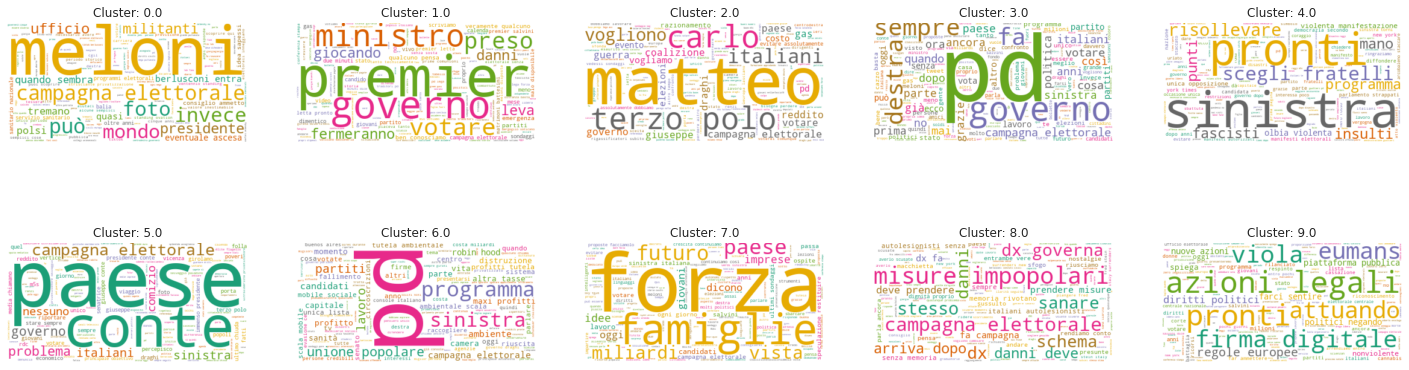

In [ ]:
sns.set()
plt.rcParams['figure.figsize'] = [25, 50]
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.4, wspace=0.2, hspace=0.1)

wordcloud = WordCloud(background_color="white", contour_width=0.1, 
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2", stopwords=stop)

for i in range(10):
    wordcloud.generate(text=word_final["text_clean"][i])   
    plt.subplot(5, 5, i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    tit = 'Cluster: ' + str(word_final["cluster"][i])
    plt.title(tit)
    plt.axis("off")
plt.show()

## IDENTIFICAZIONE BOT

In [ ]:
id_bot = df[df['text'].str.contains('GRANDE RESET')]
id_bot.head(4)

,date,id,text,n_rt,n_like,author_name,author_id,location,rt_authors,author_follower,author_friends,rt_names
17,2022-09-01 10:49:32+00:00,1565290754985033730,"GRANDE RESET,\nSE LI RIVOTI, CONTINUERANNO L'A...",0,1,Erica43581765,1469261811497197573,NaN,[],621,583,[]
82,2022-09-01 10:42:14+00:00,1565288917217300481,"GRANDE RESET,\nSE LI RIVOTI, CONTINUERANNO L'A...",0,0,Erica43581765,1469261811497197573,NaN,[],621,583,[]
190,2022-09-01 10:28:47+00:00,1565285532191571969,"GRANDE RESET,\nSE LI RIVOTI, CONTINUERANNO.\n#...",4,0,Bad_Linhat,2967886973,NaN,"[{'screen_name': 'Erica43581765', 'name': 'Eri...",1410,2976,[Erica43581765]
196,2022-09-01 10:28:27+00:00,1565285450901848064,"GRANDE RESET,\nSE LI RIVOTI, CONTINUERANNO L'A...",3,0,NOWARNONATONOU1,1562334251042762752,NaN,"[{'screen_name': 'Erica43581765', 'name': 'Eri...",11,37,[Erica43581765]


In [ ]:
## Ricerco le persone che hanno più tweettato questo tweet
id_bot.groupby('author_name')['id'].count().reset_index().sort_values(by='id', ascending=False)

,author_name,id
25,NOWARNONATONOU1,147
58,savedem65052841,141
13,Erica43581765,133
12,Eric57017912,92
17,GiancarloPilus1,23
...,...,...
1,Alberto93383706,1
32,RaffaellaP6,1
33,RobbyDreamer,1
35,Sara_snf,1


In [ ]:
## il nostro è un grafo diretto, per andare a controllare le cricche è necessario
## trasformarlo in indiretto per poter utilizzare la funzione enumerate_all_cliques
nx.is_directed(weight_graph)
print('Nodi:', weight_graph.number_of_nodes())
print('Archi:', weight_graph.number_of_edges())

Nodi: 12947
Archi: 27096


In [ ]:
## trasformo da diretto a indiretto
G = weight_graph.to_undirected()
nx.is_directed(G)
print('Nodi:', G.number_of_nodes())
print('Archi:', G.number_of_edges())

Nodi: 12947
Archi: 26865


In [ ]:
sospetto = ['Erica43581765']

In [ ]:
## Ricerca cricche
for i,x in enumerate(nx.enumerate_all_cliques(G)):
  for b in sospetto:
    if b in x and len(x)>3:
      print(i,x)

49222 ['Erica43581765', 'NOWARNONATONOU1', 'savedem65052841', 'Eric57017912']
49223 ['Erica43581765', 'NOWARNONATONOU1', 'AndreaM66756268', 'Eric57017912']
49224 ['Erica43581765', 'savedem65052841', 'Eric57017912', 'GiancarloPilus1']
49225 ['Erica43581765', 'savedem65052841', 'Eric57017912', 'BearziCinzia66']
49226 ['Erica43581765', 'savedem65052841', 'Eric57017912', 'Sbrn65']
49227 ['Erica43581765', 'savedem65052841', 'Eric57017912', 'Paola18439710']
49228 ['Erica43581765', 'savedem65052841', 'Eric57017912', 'freedom_474']
49229 ['Erica43581765', 'savedem65052841', 'Eric57017912', 'Loredanataberl1']
49230 ['Erica43581765', 'savedem65052841', 'Eric57017912', 'PEACEFREEDOM202']
49231 ['Erica43581765', 'savedem65052841', 'Eric57017912', 'PiazzaAngelo1']


In [ ]:
bot = ['NOWARNONATONOU1','Erica43581765', 'PEACEFREEDOM20256268', 'savedem65052841', 'Eric57017912']

In [ ]:
df_nobot=df[~df['author_name'].isin(bot)]

In [ ]:
df_nobot.shape

(34358, 12)

In [ ]:
df_nobot.head(5)

,date,id,text,n_rt,n_like,author_name,author_id,location,rt_authors,author_follower,author_friends,rt_names
0,2022-09-01 10:51:41+00:00,1565291297640009728,"Ehi, sarà mica il #Giornodellamarmotta ?\n\nFe...",1,0,whilecromar,347209343,Milano - Cremona - Parma,"[{'screen_name': 'terzopolomeme', 'name': 'Ter...",707,1323,"[terzopolomeme, gar_fal, CarloCalenda]"
1,2022-09-01 10:51:38+00:00,1565291282053881857,#Elezioni2022 #ElezioniPolitiche\n\nElenco dei...,1,0,GiuliaTulla,113398061,NaN,"[{'screen_name': 'OrioliAlberto', 'name': 'Alb...",1935,1766,[OrioliAlberto]
2,2022-09-01 10:51:36+00:00,1565291275208822784,"Eh sì, stamattina ho avuto un brutto risveglio...",0,0,CapoOrsoInPiedi,1024757342066421761,NaN,[],417,899,[]
3,2022-09-01 10:51:27+00:00,1565291238424805379,Scusate la classe.....😜😂😂😂\n#ElezioniPolitiche...,7,0,AndreaCalussi,1295089147456172032,NaN,"[{'screen_name': 'AlessandraOdri', 'name': 'Al...",39,90,[AlessandraOdri]
4,2022-09-01 10:51:07+00:00,1565291155377602562,#Elezioni2022 \nEuropa Verde ha pubblicato una...,35,0,sergiopbaviera,34617925,"Palermo, Italy","[{'screen_name': 'ultimora_pol', 'name': 'Ulti...",922,2631,[ultimora_pol]
